## Interpolación

In [1]:
# Esto hay que ejecutarlo solo en Colab para cargar el modulo propio Solsislin dentro del entorno de ejecucion
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# El archivo Solsislin.py debe estar en la raiz de su drive para que esta instrucccion funcione
# si no, cambie por la ruta adecuada dentro de su drive
!cp /content/drive/MyDrive/Solsislin.py .

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Solsislin import triDiagluSol

In [4]:
# Funciones auxiliares

## Derivada numerica
def derivada(f,x,tol = 1e-12, maxiter = 500):
    """Calcula la derivada de f en x (f'(x)) mediante diferencias progresivas.
    
    - Entrada >    
      f (function)  - Funcion de la cual se quiere conocer su derivada.
      x (float)     - Punto donde se quiere conocer el valor de f'.
      tol (float)   - Opcional. Tolerancia para la diferencia entre dos aproximaciones.
      maxiter (int) - Opcional. Numero maximo de iteraciones.
    
    - Salida >
      dfx (float) - Valor aproximado de f'(x).
    """
    d,h,it = np.inf,0.5,1
    dfx_a = f(x+1) - f(x)
    while abs(d) > tol and it < maxiter:
        dfx = (f(x+h) - f(x)) / h
        d = dfx - dfx_a
        dfx_a = dfx
        h /= 2
        it += 1
    return dfx

## Funciones de prueba
f1 = lambda x:np.sin(np.exp(x**2))
f2 = lambda x:5.0*np.sin(x)/(x+np.exp(-0.75*x)) - 3.0*x/5.0

### Interpolación de Newton

SUpongamos que $P_{n}(x)$ es el n-ésimo *polinomio de Lagrange* que concuerda con la función $f$ en los números distintos $x_{0},x_{1},\ldots,x_{n}$. Las **diferencias divididas** de $f$ respecto a $x_{0},x_{1},\ldots,x_{n}$ se usan para expresar $P_{n}(x)$ en la forma
$$
    P_{n}(x) = a_{0} + a_{1}(x-x_{0}) + a_{2}(x-x_{0})(x-x_{1}) + \cdots + a_{n}\prod_{j=0}^{n-1}(x-x_{j})
$$

para las constantes apropiadas $a_{0},a_{1},\ldots,a_{n}$. Estás constantes requeridas están dadas por

$$
    a_{k} = f[x_{0},x_{1},x_{2},\ldots,x_{k}]
$$

para $k = 0,1,\ldots,n$ donde $f[x_{0},x_{1},x_{2},\ldots,x_{k}]$ es la k-ésima diferencia dividida relativa a $x_{0},x_{1},x_{2},\ldots,x_{k}$. por lo tanto se puede reescribir $P_{n}(x)$ como
$$
    P_{n} = f[x_{0}] + \sum_{k=1}^{n}f[x_{0},x_{1},x_{2},\ldots,x_{k}]\prod_{j=0}^{k-1}(x-x_{j})
$$

A esta ecuación se le conoce con el nombre de **fórmula de diferencias divididas interpolantes de Newton**.

Para implementar esto es necesario calcular las diferencias divididas. Por ejemplo, para $x_0,x_{1},x_{2}$ y $x_{3}$ y $f(x_0),f(x_{1}),f(x_{2})$ y $f(x_{3})$ es necesario calcular

| $$x$$ | $$f(x)$$ | Primeras diferencias  divididas | Segundas diferencias  divididas | Terceras diferencias  divididas |
|:---:|:---:|:---:|:---:|:---:|
| $$x_{0}$$ | $$f[x_{0}]$$ |  |  |  |
| $$x_{1}$$ | $$f[x_{1}]$$ | $$f[x_{0},x_{1}] = \dfrac{f[x_{1}] - f[x_{0}]}{x_{1}-x_{0}}$$ |  |  |
| $$x_{2}$$ | $$f[x_{2}]$$ | $$f[x_{1},x_{2}] = \dfrac{f[x_{2}] - f[x_{1}]}{x_{2}-x_{1}}$$ | $$f[x_{0},x_{1},x_{2}] = \dfrac{f[x_{1},x_{2}] - f[x_{0},x_{1}]}{x_{2}-x_{0}}$$ |  |
| $$x_{3}$$ | $$f[x_{3}]$$ | $$f[x_{2},x_{3}] = \dfrac{f[x_{3}] - f[x_{2}]}{x_{3}-x_{2}}$$ | $$f[x_{1},x_{2},x_{3}] = \dfrac{f[x_{2},x_{3}] - f[x_{1},x_{2}]}{x_{3}-x_{1}}$$ | $$f[x_{0},x_{1},x_{2},x_{3}] = \dfrac{f[x_{1},x_{2},x_{3}] - f[x_{0},x_{1},x_{2}]}{x_{3}-x_{1}}$$ |

Si se considera la tabla anterior como una matriz ```F```, la primera columna que corresponde al indice ```0``` tendría los valores de las diferencias divididas de orden cero, esto es, ```F[j,0]``` = $f[x_{j}]$, $j=0,\ldots,n$. Luego, las primeras diferencias divididas estarían en la segunda columna, ```F[j,1]``` = $f[x_{j-1},x_{j}]$, $j=1,\ldots,n$.  En general, la k-ésima columna de ```F``` contendría la $k$-ésima diferencia dividida relativa a $x_{j-k},x_{j- k + 1},\ldots,x_{j}$ para $j=k,\ldots,n$, es decir

* ```F[j,k]``` = $f[x_{j-k},x_{j- k + 1},\ldots,x_{j}] \quad j = k,\ldots,n$

para $k = 0,\ldots,n$. De esta manera, se pueden ir calculando por renglones las diferencias divididas que son necesarias para la fórmula de diferencias divididas interpolantes de Newton y que se encuentran en la diagonal de la matriz ```F```.

In [5]:
def ddnewton(x,fx):
    """ Funcion que calcula la formula de diferencias divididas interpolantes de
    Newton (Algoritmo 3.2 Richard L. Burden).
    
    - Entrada >
      x (1D ndarray)  - Vector de tamaño n con los valores de las abscisas.
      fx (1D ndarray) - Vector de tamaño n con las valuaciones de los puntos x_j  
                        en alguna funcion continua f desconocida.
                        
    - Salida >
      (1D ndarray) - Vector de tamaño n con los coeficientes de las 
                     diferencias divididas del polinomio interpolante.
    """
    n = fx.size
    F = np.zeros((n,n))
    F[:,0] = fx
    for i in range(n-1):
        for j in range(i+1):
            F[i+1,j+1] = (F[i+1,j]-F[i,j])/(x[i+1]-x[i-j])
    return F.diagonal()

In [6]:
def interpNewton(x,fx,p,fun = None):
    """Funcion que realiza la interpolacion mediante diferencias divididas 
    interpolantes de Newton.
    
    - Entrada >
      x (1D ndarray)  - Vector de tamaño n con los valores de las abscisas.
      fx (1D ndarray) - Vector de tamaño n con las valuaciones de los puntos x_j  
                        en alguna funcion continua f desconocida.
      p (1D ndarray)  - Vector de tamaño m con abscisas en las cuales se quiere
                        conocer el valor de la funcion continua f desconocida.
      fun (function)  - Funcion f.
    """
    F = ddnewton(x,fx)
    n = p.size
    fp = np.zeros((n,))
    for k in range(n):
        fp[k] = F[0]
        for i in range(1,x.size):
            fac = np.prod(p[k]-x[:i])
            fp[k] += F[i]*fac    
    if fun is not None:
        plt.plot(p,fun(p),'--',color = 'steelblue',label = 'Funcion',lw=2)
    plt.plot(p,fp,color='firebrick',label = 'Interpolante',lw=2)
    plt.plot(x,fx,'o',markersize = 7,color = 'olivedrab',label = 'Datos')
    ax = plt.gca()
    ax.legend()
    plt.show()

#### Ejemplos

In [7]:
# Datos
fun = f1 #Funcion
inter = (-1,1) # Intervalo
npts = 5 #No. de puntos

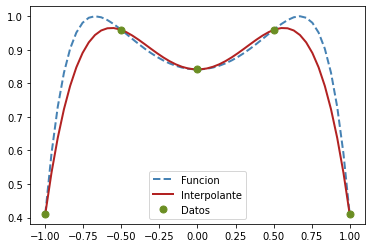

In [8]:
x = np.linspace(inter[0],inter[1],npts)
fx = fun(x)
p = np.linspace(inter[0],inter[1])
interpNewton(x,fx,p,fun)

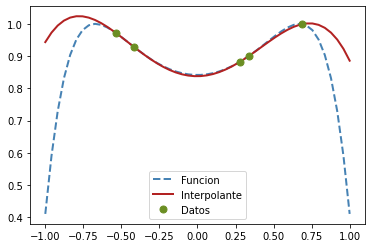

In [9]:
x = inter[0] + (inter[1] - inter[0])*np.random.rand(npts)
x.sort()
fx = fun(x)
p = np.linspace(inter[0],inter[1])
interpNewton(x,fx,p,fun)

### Interpolación de Hermite

Un método para generar las aproximaciones de Hermite tiene como base la fórmula de diferencias divididas interpolantes de Newton para el polinomio de Lagrange en $x_{0},x_{1},\ldots,x_{n}$, $P_{n}(x)$, y la conexión entre la $n$-esima diferencia dividida y la derivada de grado $n$ de $f$.

Supongase que los números distintos $x_{0},x_{1},\ldots,x_{n}$ están dados junto con los valores de sus evaluaciones en $f$ y $f'$. Definase la sucesión $z_{0},z_{1},\ldots,z_{2n+1}$ mediante

$$
    z_{2i} = z_{2i+1} = x_{i} \quad i=0,1,\ldots,n
$$

y se construye una tabla de diferencias divididas para estos valores, de forma análoga como en el caso del interpolante de Newton. Dado que $z_{2i} = z_{2i+1} = x_{i}$ para cada $i$, no se puede definir $f[z_{2i},z_{2i+1}]$ a partir de la fórmula de diferencias divididas. Si se supone que

$$
    f[z_{2i},z_{2i+1}] = f'(z_{2i}) = f'(x_{i}) \quad i=0,\ldots,n
$$

entonces las diferencias divididas de primer orden quedarían definidas ya que se conocen los valores de $f'(x_{i})$. Con esto, las diferencias divididas restantes se pueden calcular y se usan las diferencias divididas apropiadas en la fórmula de diferencias divididas interpolantes de Newton. Esto ya que se puede probar que el polinomio de Hermite está dado por

$$
    H_{2n+1}(x) = f[z_{0}] + \sum_{k=1}^{2n+1}f[z_{0},z_{1},z_{2},\ldots,z_{k}]\prod_{j=0}^{k-1}(x-z_{j})
$$

Por ejemplo, para determinar el polinomio $H_{5}(x)$ para $x_{0},x_{1},x_{2}$, la siguiente tabla contiene los datos que se usan en las columnas de las tres primeras diferencias divididas

| $$x$$ 	| $$f(x)$$ 	| Primeras diferencias  divididas 	| Segundas diferencias  divididas 	|
|---	|---	|---	|---	|
| $$z_{0} = x_{0}$$ 	| $$f[z_{0}] = f(x_{0})$$ 	|  	|  	|
| $$z_{1} = x_{0}$$ 	| $$f[z_{1}] = f(x_{0})$$ 	| $$f[z_{0},z_{1}] = f'(x_{0})$$ 	|  	|
| $$z_{2} = x_{1}$$ 	| $$f[z_{2}] = f(x_{1})$$ 	| $$f[z_{1},z_{2}] = \dfrac{f[z_{4}] - f[z_{3}]}{z_{4}-z_{3}}$$ 	| $$f[z_{0},z_{1},z_{2}] = \dfrac{f[z_{1},z_{2}] - f[z_{0},z_{1}]}{z_{2}-z_{0}}$$ 	|
| $$z_{3} = x_{1}$$ 	| $$f[z_{3}] = f(x_{1})$$ 	| $$f[z_{2},z_{3}] = f'(x_{1})$$ 	| $$f[z_{1},z_{2},z_{3}] = \dfrac{f[z_{2},z_{3}] - f[z_{1},z_{2}]}{z_{3}-z_{1}}$$ 	|
| $$z_{4} = x_{2}$$ 	| $$f[z_{4}] = f(x_{2})$$ 	| $$f[z_{3},z_{4}] = \dfrac{f[z_{4}] - f[z_{3}]}{z_{4}-z_{3}}$$ 	| $$f[z_{2},z_{3},z_{4}] = \dfrac{f[z_{3},z_{4}] - f[z_{2},z_{3}]}{z_{4}-z_{2}}$$ 	|
| $$z_{5} = x_{2}$$ 	| $$f[z_{5}] = f(x_{2})$$ 	| $$f[z_{4},z_{5}] = f'(x_{2})$$ 	| $$f[z_{3},z_{4},z_{5}] = \dfrac{f[z_{4},z_{5}] - f[z_{3},z_{4}]}{z_{5}-z_{3}}$$ 	|

Las demás diferencias divididas se cálculan como en el caso del interpolante de Newton

In [10]:
def ddhermite(x,fx,dfx):
    """ Calcula los coeficientes del polinomio interpolante de Hermite H_{2n+1}(x)
    (Algoritmo 3.3 Richard L. Burden).
    
    - Entrada >
      x (1D ndarray)  - Vector de tamaño n con los valores de las abscisas.
      fx (1D ndarray) - Vector de tamaño n con las valuaciones de los puntos x_j  
                        en alguna funcion continua f desconocida.
      dfx (1D ndarray) - Vector de tamaño n con las valuaciones de los puntos x_j  
                         en la derivada de alguna funcion continua f desconocida.
                        
    - Salida >
      (1D ndarray) - Vector de tamaño n con los puntos z_{2i} = z_{2i+1} = x_{i}.
      (1D ndarray) - Vector de tamaño n con los coeficientes de las 
                     diferencias divididas del polinomio interpolante.
    """
    Q = np.zeros((2*x.size,2*x.size+1))
    Q[::2,0] = Q[1::2,0] = x.copy()
    Q[::2,1] = Q[1::2,1] = fx.copy()
    Q[1::2,2] = dfx.copy()
    Q[2::2,2] = (Q[1:-1:2,1] - Q[2:-1:2,1])/((Q[1:-1:2,0] - Q[2:-1:2,0]))
    for i in range(1,2*x.size-1):
        for j in range(1,i+1):
            Q[i+1,j+2] = (Q[i+1,j+1]-Q[i,j+1])/(Q[i+1,0]-Q[i-j,0])
    return Q[:,0],Q.diagonal(1)

In [11]:
def interpHermite(x,fx,dfx,p,fun = None):
    """Funcion que realiza la interpolacion mediante el polinomio de Hermite H_{2n+1}(x)
    
    - Entrada >
      x (1D ndarray)  - Vector de tamaño n con los valores de las abscisas.
      fx (1D ndarray) - Vector de tamaño n con las valuaciones de los puntos x_j  
                        en alguna funcion continua f desconocida.
      dfx (1D ndarray) - Vector de tamaño n con las valuaciones de los puntos x_j  
                         en la derivada de alguna funcion continua f desconocida.
      p (1D ndarray)  - Vector de tamaño m con abscisas en las cuales se quiere
                        conocer el valor de la funcion continua f desconocida.
      fun (function)  - Funcion f.
    """
    z,Q = ddhermite(x,fx,dfx)
    n = p.size
    fp = np.zeros((n,))
    for k in range(n):
        fp[k] = Q[0]
        for i in range(1,z.size):
            fac = np.prod(p[k]-z[:i])
            fp[k] += Q[i]*fac
    if fun is not None:
        plt.plot(p,fun(p),'--',color = 'steelblue',label = 'Funcion',lw=2)
    plt.plot(p,fp,color='firebrick',label = 'Interpolante',lw=2)
    plt.plot(x,fx,'o',markersize = 7,color = 'olivedrab',label = 'Datos')
    ax = plt.gca()
    ax.legend()
    plt.show()

#### Ejemplos

##### Ejemplo 1

Utilizar el polinomio de Hermite que concuerda con los datos de la siguiente tabla para obtener una aproximación de $f(1.5)$

| $$k$$ | $$x_{k}$$ | $$f(x_{k})$$ | $$f'(x_{k})$$ |
|-----|---------|------------|-------------|
| 0   | 1.3     | 0.6200860  | -0.5220232  |
| 1   | 1.6     | 0.4554022  | -0.5698959  |
| 2   | 1.9     | 0.2818186  | -0.5811571  |

In [12]:
x = np.array([1.3,1.6,1.9])
fx = np.array([0.6200860,0.4554022,0.2818186])
dfx = np.array([-0.5220232,-0.5698959,-0.5811571])

In [13]:
# Se contruye el espacio de la tabla
Q = np.zeros((2*x.size,2*x.size+1))

# Puntos z, y diferencias divididas de orden 0 y 1
Q[::2,0] = Q[1::2,0] = x.copy() #z_{2i} y #z_{2i+1}
Q[::2,1] = Q[1::2,1] = fx.copy() #f_{z_i}
Q[1::2,2] = dfx.copy() #f'_{x_i}
Q[2::2,2] = (Q[1:-1:2,1] - Q[2:-1:2,1])/((Q[1:-1:2,0] - Q[2:-1:2,0])) # f[z_{i},z_{i+1}]

# Se calcula el resto de las diferencias divididas
for i in range(1,2*x.size-1):
    for j in range(1,i+1):
        Q[i+1,j+2] = (Q[i+1,j+1]-Q[i,j+1])/(Q[i+1,0]-Q[i-j,0])
with np.printoptions(precision=6, suppress=True):
    print("Tabla de diferencias divididas ",Q,sep="\n\n")

Tabla de diferencias divididas 

[[ 1.3       0.620086  0.        0.        0.        0.        0.      ]
 [ 1.3       0.620086 -0.522023  0.        0.        0.        0.      ]
 [ 1.6       0.455402 -0.548946 -0.089743  0.        0.        0.      ]
 [ 1.6       0.455402 -0.569896 -0.069833  0.066366  0.        0.      ]
 [ 1.9       0.281819 -0.578612 -0.029054  0.067966  0.002667  0.      ]
 [ 1.9       0.281819 -0.581157 -0.008484  0.068567  0.001002 -0.002775]]


Los elementos de la diagonal principal de la matriz ```Q[:,1:]``` corresponden a los coeficientes necesarios para construir el polinomio interpolante de Hermite dado por
$$
    H_{5}(x) = 0.620086 - 0.522023(x - 1.3) - 0.089743(x - 1.3)^2 + 0.066366(x - 1.3)^2(x - 1.6) + 0.002667(x - 1.3)^2(x - 1.6)^2 - 0.002775(x - 1.3)^2(x - 1.6)^2(x - 1.9)
$$

Hay que evaluar el polinomio $H_{5}(1.5)$ para obtener la aproximación de $f(1.5)$.

In [14]:
p = 1.5
z = Q[:,0]
Q = Q.diagonal(1)
fp = Q[0]
for i in range(1,z.size):
    fac = np.prod(p-z[:i])
    fp += Q[i]*fac
print(f"El valor aproximado de f({p}) = {fp:.6f}")

El valor aproximado de f(1.5) = 0.511828


##### Ejemplo 2

In [15]:
fun = f1 #Funcion
inter = (-1,1) # Intervalo
npts = 5 #No. de puntos

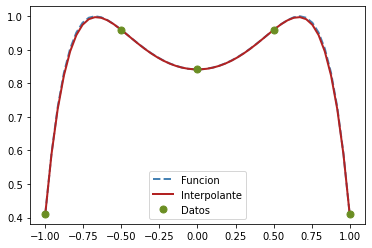

In [16]:
x = np.linspace(inter[0],inter[1],npts)
fx = fun(x)
dfx = np.array(list(map(lambda x:derivada(fun,x),x)))
p = np.linspace(inter[0],inter[1])
interpHermite(x,fx,dfx,p,fun)

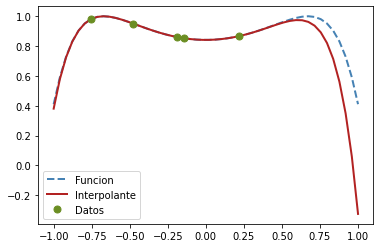

In [17]:
x = inter[0] + (inter[1] - inter[0])*np.random.rand(npts)
x.sort()
fx = fun(x)
dfx = np.array(list(map(lambda x:derivada(fun,x),x)))
p = np.linspace(inter[0],inter[1])
interpHermite(x,fx,dfx,p,fun)

### Spline cúbico natural

Dada una función $f$ definida en $[a,b]$ y un conjunto de nodos $a = x_{0} < x_{1} < \ldots < x_{n} = b$ un **interpolante de spline cúbico natural** $S$ para $f$ es una función que cumple con las siguientes condiciones:

1. $S(x)$ es un polinomio cúbico, denotado $S_{j}(x)$, en el intervalo $[x_{j},x_{j+1}]$ para cada $j=0,1,\ldots,n-1$;
2. $S(x_{j}) = f(x_{j})$ para cada $j=0,1,\ldots,n$;
3. $S_{j+1}(x_{j+1}) = S_{j}(x_{j+1})$ para cada $j=0,1,\ldots,n-2$;
4. $S'_{j+1}(x_{j+1}) = S'_{j}(x_{j+1})$ para cada $j=0,1,\ldots,n-2$;
5. $S''_{j+1}(x_{j+1}) = S''_{j}(x_{j+1})$ para cada $j=0,1,\ldots,n-2$;
6. $S''(x_{0}) = S''(x_{n}) = 0$

Si se quiere construir el interpolante del spline cúbico natural de determinada función $f$ se aplicn las condiciones a los polinomios cúbicos:

$$
    S_{j}(x) = a_{j} + b_{j}(x-x_{j}) + c_{j}(x-x_{j})^{2} + d_{j}(x-x_{j})^{3}
$$

para cada $j=0,1,\ldots,n-1$. Utilizando las condiciones que definen el spline natural se tiene que

$$
    a_{j} = f(x_{j})\quad j = 0,1,\ldots,n\\
    d_{j} = \dfrac{(c_{j+1}-c_{j})}{3h_{j}}\quad j = 0,1,\ldots,n-1\\
    b_{j} = \dfrac{(a_{j+1}-a_{j})}{h_{j}} - \dfrac{h_{j}(2c_{j}+c_{j+1})}{3}\quad j = 0,1,\ldots,n-1\\
$$

con $h_{j} = x_{j+1} - x_{j}$. Al final, utilizando otras expresiones (vae los detalles en el libro de Burden), se obtiene el sistema de ecuaciones lineales

$$
    h_{j-1}c_{j-1} + 2(h_{j-1} + h_{j})c_{j} + h_{j}c_{j+1} = \dfrac{3(a_{j+1} - a_{j})}{h_{j}} - \dfrac{3(a_{j} - a_{j-1})}{h_{j-1}}
$$

para $j = 1,2,\ldots,n-1$. Dicho sistema sólo contiene $\{c_{j}\}_{j=0}^{n}$ como incógnitas ya que los valores $\{a_{j}\}_{j=0}^{n}$ y $\{h_{j}\}_{j=0}^{n-1}$ son conocidos ya que dependen de $\{x_{j}\}_{j=0}^{n}$ y $\{f(x_{j})\}_{j=0}^{n}$.

Dado que se tienen $n-1$ ecuaciones y $n+1$, se usan las condiciones del spline natural dadas en el punto 6, lo cual nos da las ecuaciones adicionales $c_{0} = c_{n} = 0$, que da el sistema tirdiagonal $A\pmb{c} = \pmb{y}$ de $(n+1)\times(n+1)$

$$
    A\pmb{c} = \begin{pmatrix}
        1 & 0 & 0 & \cdots & \cdots & 0\\
        h_{0} & 2(h_{0} + h_{1}) & h_{1}  & \ddots &  & \vdots\\
        0 & h_{1} & 2(h_{1} + h_{2}) & h_{2}& \ddots &  \vdots\\
        \vdots & \ddots  &\ddots  & \ddots & \ddots & 0\\
        \vdots & &\ddots  & h_{n-2} & 2(h_{n-1} + h_{n-1}) & h_{n-1}\\
        0 & \cdots & \cdots & 0 & 0 & 1
    \end{pmatrix}\begin{pmatrix}
        c_{0} \\ c_{1} \\ c_{2} \\ \vdots \\ c_{n-1} \\ c_{n}
    \end{pmatrix} =
    \begin{pmatrix}
       0 \\ \dfrac{3(a_{2} - a_{1})}{h_{1}} - \dfrac{3(a_{1} - a_{0})}{h_{0}} \\ \dfrac{3(a_{3} - a_{2})}{h_{2}} - \dfrac{3(a_{2} - a_{1})}{h_{1}} \\ \vdots \\\dfrac{3(a_{n} - a_{n-1})}{h_{n-1}} - \dfrac{3(a_{n-1} - a_{n-2})}{h_{n-2}} \\ 0
    \end{pmatrix} = \pmb{y}    
$$

donde la matriz $A$ es diagonal dominante y por tanto el vector $\pmb{c}$ es único. Una vez obtenido $\pmb{c}$ se pueden calcular $\{d_{j}\}_{j=0}^{n-1}$ y $\{b_{j}\}_{j=0}^{n-1}$.

#### Algoritmo (Spline cúbico natural)

* *Entrada* - $\{x_{j}\}_{j=0}^{n+1}$ en $[a,b]$, con $a = x_{0} < x_{1} < \ldots < x_{n} = b$ y $\{f(x_{j})\}_{j=0}^{n+1}$ sus evaluaciones en una función $f$.
* *Salida*  - $\{a_{j}\}_{j=0}^{n}$, $\{b_{j}\}_{j=0}^{n-1}$, $\{c_{j}\}_{j=0}^{n}$ y $\{d_{j}\}_{j=0}^{n-1}$, coeficientes de los polinomios cúbicos $S_{j}(x) = a_{j} + b_{j}(x-x_{j}) + c_{j}(x-x_{j})^{2} + d_{j}(x-x_{j})^{3}$ para $j=0,1,\ldots,n-1$.

1. **Definir** $a_{j} = f(x_{j})$, $j=0,1,\ldots,n$.
2. **Calcular** $h_{j} = x_{j+1} - x_{j}$, $j=0,1,\ldots,n-1$.
3. **Construir** $A$ y $\pmb{y}$.
4. **Resolver** $A\pmb{c} = \pmb{y}$.
5. **Calcular** $b_{j}$ y $d_{j}$, $j=0,1,\ldots,n-1$.
6. **Regresar** $\{a_{j}\}_{j=0}^{n}$, $\{b_{j}\}_{j=0}^{n-1}$, $\{c_{j}\}_{j=0}^{n}$ y $\{d_{j}\}_{j=0}^{n-1}$.

In [18]:
def splinecub_N(x,fx):
    """ Calcula los coeficientes a_{j}, b_{j}, c_{j} y d_{j} de los polinomios cubicos S_{j} de un
    spline natural.
    
    - Entrada >
      x (1D ndarray)  - Vector con los puntos que definen las abscisas x_{j}. 
                        Se supone que son distintos y estan ordenados.
      fx (1D ndarray) - Vector con los puntos que definen las ordenadas f(x_{j}). 
      
    - Salida >
      a (1D ndarray) - Coeficientes a_{j} del polinomio cúbico S_{j} en el intervalo [x_{j},x_{j+1}].
      b (1D ndarray) - Coeficientes b_{j} del polinomio cúbico S_{j} en el intervalo [x_{j},x_{j+1}].
      c (1D ndarray) - Coeficientes c_{j} del polinomio cúbico S_{j} en el intervalo [x_{j},x_{j+1}].
      d (1D ndarray) - Coeficientes d_{j} del polinomio cúbico S_{j} en el intervalo [x_{j},x_{j+1}].
    """
    # Se asigna a_{j} y se calcula h_{j}
    a = fx
    h = x[1:] - x[:-1]
    
    # Se construye A y el lado derecho y. Se resuelve el sistema Ac = y
    dp,rhs = np.ones((x.size,)),np.zeros((x.size,))
    dp[1:-1] = 2.0*(h[:-1] + h[1:])
    rhs[1:-1] = 3.0*(a[2:]-a[1:-1])/h[1:] - 3*(a[1:-1]-a[:-2])/h[:-1]    
    c = triDiagluSol(dp,np.append(h[:-1],0),np.append(0,h[1:]),rhs)
    
    # Se calcula b_{j} y d_{j}
    b = (a[1:]-a[:-1])/h - h*(2.0*c[:-1] + c[1:])/3.0
    d = (c[1:] - c[:-1])/(3.0*h)
    return a,b,c,d

def plotSC_N(x,fx,coef,fun = None):
    """ Hace la gráfica del spline natural
    
    - Entrada >
      x (1D ndarray)  - Vector con los puntos que definen las abscisas x_{j}. 
                        Se supone que son distintos y estan ordenados.
      fx (1D ndarray) - Vector con los puntos que definen las ordenadas f(x_{j}).
      coef (tupla)    - Es una tupla de tamaño 4 donde cada una de sus entradas corresponden
                        a los coeficientes a_{j}, b_{j}, c_{j}, d_{j} del spline natural S.
                        Vease la función splinecub_N para más detalles.
    """
    if fun is not None:
        p = np.linspace(x[0],x[-1])
        plt.plot(p,fun(p),'--',color = 'steelblue',label = 'Funcion',lw=2)
    for i in range(x.size-1):
        p = np.linspace(x[i],x[i+1])
        Sp = coef[0][i] + coef[1][i]*(p-x[i]) \
             + coef[2][i]*(p-x[i])**2 + coef[3][i]*(p-x[i])**3
        if i == 0:
            plt.plot(p,Sp,color='firebrick',lw=2,label = 'Interpolante')
        else:
            plt.plot(p,Sp,color='firebrick',lw=2)
    plt.plot(x,fx,'o',markersize = 7,color = 'olivedrab',label = 'Datos')
    ax = plt.gca()
    ax.legend()
    plt.show()

#### Ejemplos

In [19]:
# Datos
fun = f2 #Funcion
inter = (-5,10) # Intervalo
npts = 7 #No. de puntos

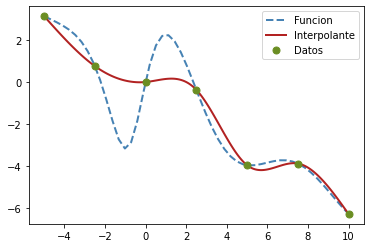

In [20]:
x = np.linspace(inter[0],inter[1],npts)
fx = fun(x)
plotSC_N(x,fx,splinecub_N(x,fx),fun)

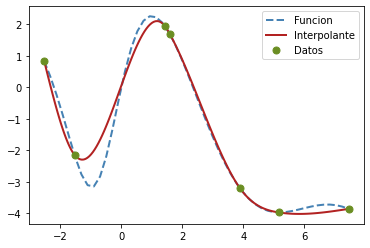

In [21]:
x = inter[0] + (inter[1] - inter[0])*np.random.rand(npts)
x.sort()
fx = fun(x)
plotSC_N(x,fx,splinecub_N(x,fx),fun)